# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](https://github.com/paulovsm/dog-breed-classifier/blob/master/images/sample_dog_output.png?raw=1)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [2]:
!cd ..
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip

--2021-05-06 15:36:48--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.120.32
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.120.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip.1’

dogImages.zip.1     100%[===================>]   1.05G  95.7MB/s    in 11s     

2021-05-06 15:37:00 (96.1 MB/s) - ‘dogImages.zip.1’ saved [1132023110/1132023110]

--2021-05-06 15:37:00--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.116.136
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.116.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 196739509 (188M) [application/zip]
Saving to: ‘lfw.zip.1’

lfw.zip.1           100%[==========

In [3]:
!rm -rf __MACOSX/
!rm -rf dogImages/
!unzip dogImages.zip
!rm -rf lfw/
!unzip lfw.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: __MACOSX/lfw/Steffi_Graf/._Steffi_Graf_0002.jpg  
  inflating: lfw/Steffi_Graf/Steffi_Graf_0003.jpg  
  inflating: __MACOSX/lfw/Steffi_Graf/._Steffi_Graf_0003.jpg  
  inflating: lfw/Steffi_Graf/Steffi_Graf_0004.jpg  
  inflating: __MACOSX/lfw/Steffi_Graf/._Steffi_Graf_0004.jpg  
  inflating: lfw/Steffi_Graf/Steffi_Graf_0005.jpg  
  inflating: __MACOSX/lfw/Steffi_Graf/._Steffi_Graf_0005.jpg  
  inflating: __MACOSX/lfw/._Steffi_Graf  
   creating: lfw/Stella_Keitel/
  inflating: lfw/Stella_Keitel/Stella_Keitel_0001.jpg  
   creating: __MACOSX/lfw/Stella_Keitel/
  inflating: __MACOSX/lfw/Stella_Keitel/._Stella_Keitel_0001.jpg  
  inflating: __MACOSX/lfw/._Stella_Keitel  
   creating: lfw/Stella_McCartney/
  inflating: lfw/Stella_McCartney/Stella_McCartney_0001.jpg  
   creating: __MACOSX/lfw/Stella_McCartney/
  inflating: __MACOSX/lfw/Stella_McCartney/._Stella_McCartney_0001.jpg  
  inflating: __MACOSX/lfw/._Stella_Mc

In [4]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


In [5]:
dog_names = [item[27:-1] for item in sorted(glob("dogImages/train/*"))]

print('Total dog classes: %d' % len(dog_names))

Total dog classes: 133


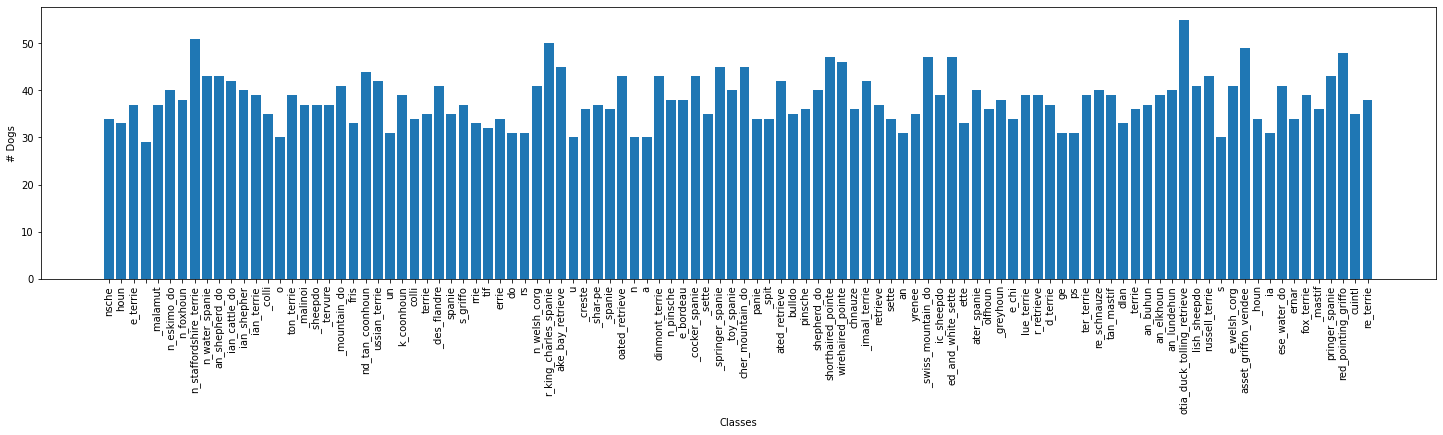

In [6]:
import matplotlib.pyplot as plt                        
%matplotlib inline

num_dogs = []
for files in sorted(glob("dogImages/train/*/")):
    num_dogs.append(len(files))
    
    
plt.figure(figsize=(25,5))
plt.xticks(rotation=90)
plt.bar(dog_names, num_dogs)
plt.xlabel('Classes')
plt.ylabel('# Dogs')
    
plt.show()

<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


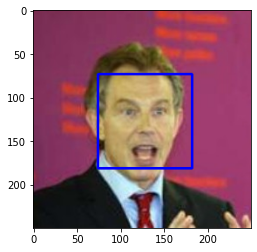

In [7]:
import cv2                                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[255])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [8]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [9]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#
faces_count_human_files = 0
faces_count_dog_files = 0

for img in human_files_short:
    faces_count_human_files += face_detector(img)
    
for img in dog_files_short:
    faces_count_dog_files += face_detector(img)

print("{:.2f}% faces found on human files".format(faces_count_human_files))
print("{:.2f}% faces found on dogs files".format(faces_count_dog_files))

100.00% faces found on human files
7.00% faces found on dogs files


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [10]:
### (Optional) 
### TODO: Test performance of another face detection algorithm.
### Feel free to use as many code cells as needed.

In [11]:
!pip install face-recognition

lfw/Gerard_Depardieu/Gerard_Depardieu_0002.jpg -> I found 2 face(s) in this photograph.


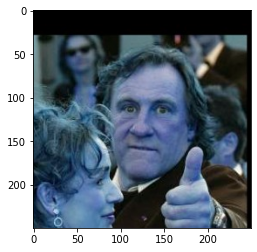

lfw/Thaksin_Shinawatra/Thaksin_Shinawatra_0005.jpg -> I found 2 face(s) in this photograph.


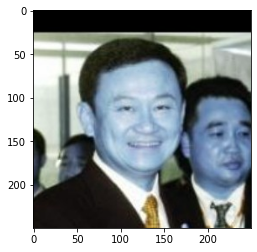

lfw/Katie_Wagner/Katie_Wagner_0001.jpg -> I found 2 face(s) in this photograph.


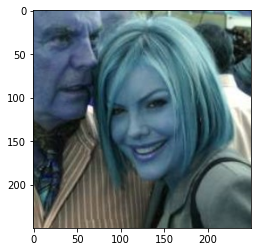

lfw/Martha_Burk/Martha_Burk_0004.jpg -> I found 2 face(s) in this photograph.


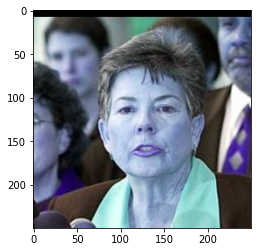

lfw/Guy_Verhofstadt/Guy_Verhofstadt_0001.jpg -> I found 2 face(s) in this photograph.


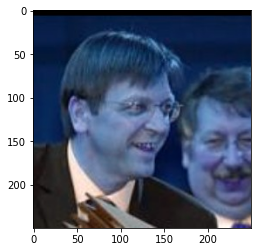

lfw/Fidel_Castro/Fidel_Castro_0013.jpg -> I found 2 face(s) in this photograph.


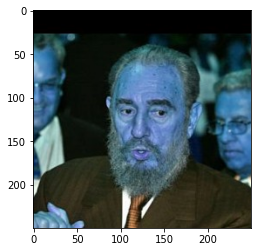

lfw/Edmund_Stoiber/Edmund_Stoiber_0013.jpg -> I found 3 face(s) in this photograph.


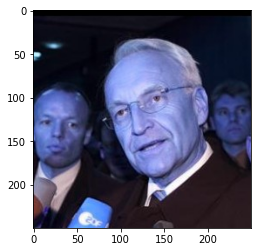

dogImages/test/030.Border_terrier/Border_terrier_02096.jpg -> I found 1 face(s) in this photograph.


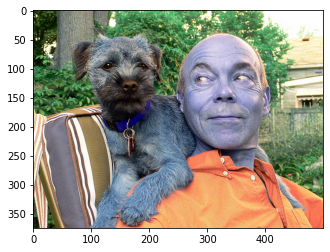

dogImages/test/024.Bichon_frise/Bichon_frise_01719.jpg -> I found 1 face(s) in this photograph.


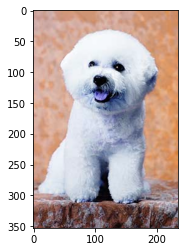

dogImages/test/039.Bull_terrier/Bull_terrier_02727.jpg -> I found 1 face(s) in this photograph.


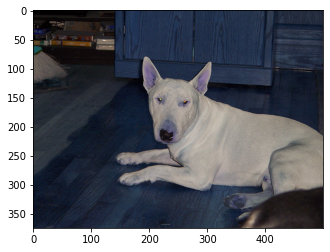

dogImages/test/039.Bull_terrier/Bull_terrier_02803.jpg -> I found 2 face(s) in this photograph.


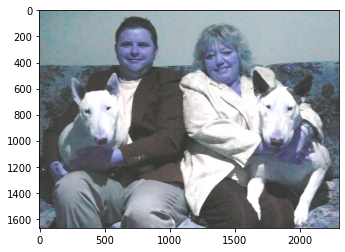

dogImages/test/002.Afghan_hound/Afghan_hound_00151.jpg -> I found 1 face(s) in this photograph.


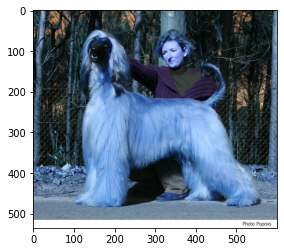

106.00% faces found on human files
6.00% faces found on dogs files


In [12]:
import face_recognition

faces_count_human_files = 0
faces_count_dog_files = 0

for img in human_files_short:
    image = face_recognition.load_image_file(img)
    face_locations = face_recognition.face_locations(image)
    faces_count_human_files += len(face_locations)
    if (len(face_locations) > 1): 
        print("{} -> I found {} face(s) in this photograph.".format(img, len(face_locations)))
        plt.imshow(cv2.imread(img))
        plt.show()
    
for img in dog_files_short:
    image = face_recognition.load_image_file(img)
    face_locations = face_recognition.face_locations(image)
    faces_count_dog_files += len(face_locations)
    if (len(face_locations) > 0): 
        print("{} -> I found {} face(s) in this photograph.".format(img, len(face_locations)))
        plt.imshow(cv2.imread(img))
        plt.show()

print("{:.2f}% faces found on human files".format(faces_count_human_files))
print("{:.2f}% faces found on dogs files".format(faces_count_dog_files))

Here I compared the performance between OpenCV with haarcascade_frontalface_alt.xml and ``Face Recognition`` library:

**OpenCV haarcascade_frontalface_alt.xml:**

* Humans detected in human_files_short: 98
* Humans detected in dog_files_short: 8

**Face Recognition Lib:**

* Humans detected in human_files_short: 102
* Humans detected in dog_files_short: 7

As we can see that we have a better performance with ``Face Recognition`` Lib, which detected all faces in human pictures including pictures with more than 1 visible face.

We also observed a decrease in the number of human faces detected in the dog_files_short. However, some dogs were still misclassified as human faces.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [13]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [14]:
from PIL import Image
import torchvision.transforms as transforms

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    # Define normalization step and transformations of image
    transform = transforms.Compose([transforms.Resize((224, 224)),                   # Resize the image to 224x224 pixels
                                    transforms.CenterCrop(224),                      # Crop image
                                    transforms.ToTensor(),                           # Convert the image to the PyTorch Tensor data type
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], # Normalizing the image with specific mean and standard deviation
                                                         std=[0.229, 0.224, 0.225])])
    
    # Load image
    img = Image.open(img_path)
    
    # Transform image
    img = transform(img).unsqueeze(0)
    
    # Move tensor to GPU if available
    if use_cuda:
        img = img.cuda()
        
    # Turn on evaluation mode
    VGG16.eval()
    
    prediction = VGG16(img)
    
    # Get the max-Value of the Tensor-matrix and return as integer
    index = torch.argmax(prediction).item()
    
    return index # predicted class index

In [15]:
# VGG16_predict sanity check
out = VGG16_predict(human_files[255])
print(out)

834


### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [16]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    
    prediction = VGG16_predict(img_path)
    
    return True if 151 <= prediction <= 268 else False

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

* Dogs detected in human_files_short: 0.0% 
* Dogs detected in dog_files_short: 100.0%


In [17]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
from tqdm import tqdm

dogs_count_human_files = 0
dogs_count_dog_files = 0

for file in tqdm(human_files_short, desc='human_files'):
    if dog_detector(file):
        dogs_count_human_files += 1

for file in tqdm(dog_files_short, desc='dog_files'):
    if dog_detector(file):
        dogs_count_dog_files += 1

print("{:.2f}% dogs found on human files".format(dogs_count_human_files))
print("{:.2f}% dogs found on dogs files".format(dogs_count_dog_files))

dog_files: 100%|██████████| 100/100 [00:01<00:00, 59.49it/s]

1.00% dogs found on human files
100.00% dogs found on dogs files


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [18]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

In [19]:
def dog_detector_multi(img_path, predictor):
    class_index = predictor(img_path)
    return 151 <= class_index <= 268

In [20]:
# define Inception model
InceptionV3 = models.inception_v3(pretrained=True)

# move model to GPU if CUDA is available
if use_cuda:
    InceptionV3 = InceptionV3.cuda()
    
def InceptionV3_predict(img_path):
    # Define normalization step and transformations of image
    transform = transforms.Compose([transforms.Resize((224, 224)),                   # Resize the image to 224x224 pixels
                                    transforms.CenterCrop(224),                      # Crop image
                                    transforms.ToTensor(),                           # Convert the image to the PyTorch Tensor data type
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], # Normalizing the image with specific mean and standard deviation
                                                         std=[0.229, 0.224, 0.225])])
    
    # Load image
    img = Image.open(img_path)
    
    # Transform image
    img = transform(img).unsqueeze(0)
    
    # Move tensor to GPU if available
    if use_cuda:
        img = img.cuda()
        
    # Turn on evaluation mode
    InceptionV3.eval()
    
    prediction = InceptionV3(img)
    
    # Get the max-Value of the Tensor-matrix and return as integer
    index = torch.argmax(prediction).item()
    
    return index # predicted class index

In [21]:
# define ResNet model
ResNet50 = models.resnet50(pretrained=True)

# move model to GPU if CUDA is available
if use_cuda:
    ResNet50 = ResNet50.cuda()
    
def ResNet50_predict(img_path):
    # Define normalization step and transformations of image
    transform = transforms.Compose([transforms.Resize((224, 224)),                   # Resize the image to 224x224 pixels
                                    transforms.CenterCrop(224),                      # Crop image
                                    transforms.ToTensor(),                           # Convert the image to the PyTorch Tensor data type
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], # Normalizing the image with specific mean and standard deviation
                                                         std=[0.229, 0.224, 0.225])])
    
    # Load image
    img = Image.open(img_path)
    
    # Transform image
    img = transform(img).unsqueeze(0)
    
    # Move tensor to GPU if available
    if use_cuda:
        img = img.cuda()
        
    # Turn on evaluation mode
    ResNet50.eval()
    
    prediction = ResNet50(img)
    
    # Get the max-Value of the Tensor-matrix and return as integer
    index = torch.argmax(prediction).item()
    
    return index # predicted class index

In [22]:
def test_model(model_name, predictor):
    dogs_count_human_files = 0
    dogs_count_dog_files = 0

    for img in human_files_short:
        dogs_count_human_files += dog_detector_multi(img, predictor)
        
    for img in dog_files_short:   
        dogs_count_dog_files += dog_detector_multi(img, predictor)
    
    print("Model: {}".format(model_name))
    print("{:.2f}% dogs found on human files".format(dogs_count_human_files))
    print("{:.2f}% dogs found on dogs files".format(dogs_count_dog_files))


In [23]:
test_model("InceptionV3", InceptionV3_predict)

Model: InceptionV3
4.00% dogs found on human files
100.00% dogs found on dogs files


In [24]:
test_model("ResNet50", ResNet50_predict)

Model: ResNet50
0.00% dogs found on human files
100.00% dogs found on dogs files


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="https://github.com/paulovsm/dog-breed-classifier/blob/master/images/Brittany_02625.jpg?raw=1" width="100"> | <img src="https://github.com/paulovsm/dog-breed-classifier/blob/master/images/Welsh_springer_spaniel_08203.jpg?raw=1" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="https://github.com/paulovsm/dog-breed-classifier/blob/master/images/Curly-coated_retriever_03896.jpg?raw=1" width="200"> | <img src="https://github.com/paulovsm/dog-breed-classifier/blob/master/images/American_water_spaniel_00648.jpg?raw=1" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="https://github.com/paulovsm/dog-breed-classifier/blob/master/images/Labrador_retriever_06457.jpg?raw=1" width="150"> | <img src="https://github.com/paulovsm/dog-breed-classifier/blob/master/images/Labrador_retriever_06455.jpg?raw=1" width="240"> | <img src="https://github.com/paulovsm/dog-breed-classifier/blob/master/images/Labrador_retriever_06449.jpg?raw=1" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [62]:
import os
import torch
from torchvision import datasets, transforms

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

data_dir = 'dogImages'

batch_size = 16

normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406], # Normalizing the image with specific mean and standard deviation
                                     std=[0.229, 0.224, 0.225])

train_transforms = transforms.Compose([transforms.Resize(size=256),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(30),
                                       transforms.RandomAffine((0, 180), translate=(0.1, 0.3), scale=(0.9, 1.3)),
                                       transforms.ColorJitter(contrast=(0.5, 1.0), saturation=(0.6, 1.0)),
                                       transforms.RandomPerspective(),
                                       transforms.ToTensor()])

validTest_transforms = transforms.Compose([transforms.Resize(size=256),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor()])

train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
valid_dataset = datasets.ImageFolder(os.path.join(data_dir, 'valid'), transform=validTest_transforms)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=validTest_transforms)

trainLoader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=0)

validLoader = torch.utils.data.DataLoader(valid_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=0)

testLoader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=0)


## Check generated sample data

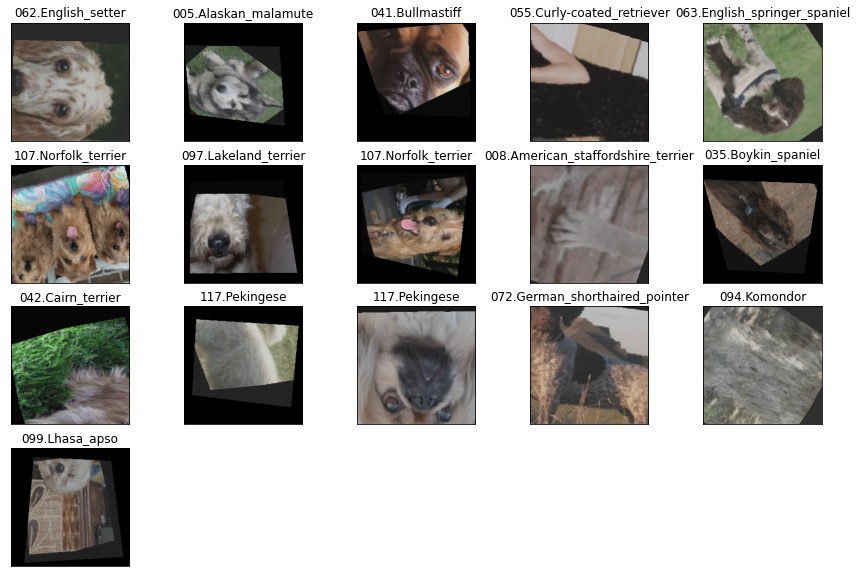

In [63]:
import matplotlib.pyplot as plt         
import numpy as np
%matplotlib inline

iterator = iter(trainLoader)
images, labels = iterator.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(15,10))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(4, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(train_dataset.classes[labels[idx].numpy()])

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:
- <em>How does your code resize the images (by cropping, stretching, etc)? What size did you pick for the input tensor, and why?</em>
    - Images were resized to 256 then cropped to a size of 224 x 224. Since the images come in various sizes resizing and cropping them to an image of 224 x 224 should be good enough especially for training time.

- <em>Did you decide to augment the dataset? If so, how (through translations, flips, rotations, etc)? If not, why not?</em>
    - Yes, I have decided for data augmentation to improve the performance of the model. I was applied a random resized crop, then a random horizontal flip and finally a random rotation of 10 degrees. It was also applied a few transformations, like Translation, Perspective distortion, Color Jitter,

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [64]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        
        ## Replicating VGG-16 architecture
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3)

        self.max_pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.20)
        
        self.fc1 =nn.Linear(256 * 5 * 5, 1024)
        self.fc2 =nn.Linear(1024, 500)
        self.fc3 =nn.Linear(500, 133)        
        
        self.conv_bn = nn.BatchNorm2d(224,3)
        self.conv_bn1 = nn.BatchNorm2d(16)
        self.conv_bn2 = nn.BatchNorm2d(32)
        self.conv_bn3 = nn.BatchNorm2d(64)
        self.conv_bn4 = nn.BatchNorm2d(128)
        self.conv_bn5 = nn.BatchNorm2d(256)
    
    def forward(self, x):
        ## Define forward behavior
        
        x = F.relu(self.conv1(x))
        x = self.max_pool(x)
        x = self.conv_bn1(x)

        x = F.relu(self.conv2(x))
        x = self.max_pool(x)
        x = self.conv_bn2(x)

        x = F.relu(self.conv3(x))
        x = self.max_pool(x)
        x = self.conv_bn3(x)

        x = F.relu(self.conv4(x))
        x = self.max_pool(x)
        x = self.conv_bn4(x)

        x = F.relu(self.conv5(x))
        x = self.max_pool(x)
        x = self.conv_bn5(x)

        x = x.view(-1, 256 * 5 * 5)

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        
        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [65]:
model_scratch

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=6400, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=133, bias=True)
  (conv_bn): BatchNorm2d(224, eps=3, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

I have a input image of 256x256 cropped to 224x224 and five convolutional layers were created. The first layer gets the tensor with depth of 3 and kernel size (3x3) and a max pooling layer is applied after each layer. Max pooling layer is added to reduce the dimensionality. Dropout was used along with flattening layer before using the fully connected layer to reduce overfitting. Considering 133 classes the fully connected layer architecture must have dimesion of 133.



### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [67]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.001, momentum=0.9)
#optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.05)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [71]:
# the following import is required for training to be robust to truncated images
import time
import datetime
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    
    # initializing history
    train_loss_hist = np.zeros(n_epochs+1).tolist()
    valid_loss_hist = np.zeros(n_epochs+1).tolist()
    valid_acc_hist = np.zeros(n_epochs+1).tolist()

    if use_cuda:
      print("CUDA available... Using CUDA")
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        valid_acc = 0.0
        epoch_start = time.time()
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            ## find the loss and update the model parameters accordingly
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        
        correct_pred = 0 
        total_classes = 0
        
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            ## update the average validation loss
            with torch.no_grad():
                output = model(data)
                
            loss = criterion(output, target)
           
            valid_loss = valid_loss+((1/ (batch_idx +1)) * (loss.data -valid_loss))
            
            # update the average validation
            pred = torch.argmax(output, 1)
            accuracy = pred.eq(target).float().detach().cpu().numpy()
            correct_pred = correct_pred + np.count_nonzero(accuracy == 1)
            total_classes = total_classes + len(target)
            
        # calculate validation accuracy
        valid_acc = correct_pred / total_classes
        
        # store metrics
        train_loss_hist[epoch] = train_loss
        valid_loss_hist[epoch] = valid_loss
        valid_acc_hist[epoch] = valid_acc
            
        # print training/validation statistics 
        print('Epoch: {}\n\tDuration: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f},  Valid. Accuracy:  {:.6f}'.format(
            epoch,
            str(datetime.timedelta(seconds= time.time() - epoch_start)),
            train_loss,
            valid_loss,
            valid_acc
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
            
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model, train_loss_hist, valid_loss_hist, valid_acc_hist


loaders_scratch = {'train': trainLoader, 'valid': validLoader, 'test': testLoader}

# train the model
model_scratch, train_loss, valid_loss, valid_acc = train(30, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

CUDA available... Using CUDA
Epoch: 1
	Duration: 0:01:46.904139 	Training Loss: 4.016798 	Validation Loss: 4.073382,  Valid. Accuracy:  0.094611
Validation loss decreased (inf --> 4.073382).  Saving model ...
Epoch: 2
	Duration: 0:01:47.023464 	Training Loss: 3.998958 	Validation Loss: 3.843946,  Valid. Accuracy:  0.108982
Validation loss decreased (4.073382 --> 3.843946).  Saving model ...
Epoch: 3
	Duration: 0:01:47.099333 	Training Loss: 3.992047 	Validation Loss: 3.984832,  Valid. Accuracy:  0.100599
Epoch: 4
	Duration: 0:01:47.083859 	Training Loss: 3.969875 	Validation Loss: 3.950723,  Valid. Accuracy:  0.097006
Epoch: 5
	Duration: 0:01:47.163202 	Training Loss: 3.961885 	Validation Loss: 3.881715,  Valid. Accuracy:  0.098204
Epoch: 6
	Duration: 0:01:49.201987 	Training Loss: 3.938342 	Validation Loss: 3.720104,  Valid. Accuracy:  0.124551
Validation loss decreased (3.843946 --> 3.720104).  Saving model ...
Epoch: 7
	Duration: 0:01:48.166770 	Training Loss: 3.914832 	Validation L

<All keys matched successfully>

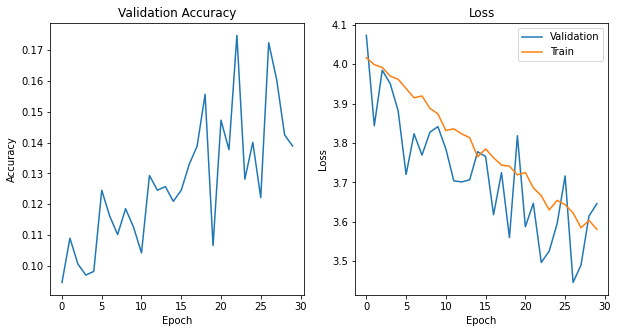

In [72]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))

# val accuracy
axs[0].set_title('Validation Accuracy')
axs[0].plot(valid_acc[1:])
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')

# loss
axs[1].set_title('Loss')
axs[1].plot(valid_loss[1:])
axs[1].plot(train_loss[1:])
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Validation', 'Train'], loc='upper right')

fig.show()

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [73]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.428662


Test Accuracy: 15% (131/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [113]:
## TODO: Specify data loaders
data_dir = 'dogImages'

batch_size = 16

train_transforms = transforms.Compose([transforms.Resize(size=256),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(30),
                                       #transforms.RandomAffine((0, 180), translate=(0.1, 0.3), scale=(0.9, 1.3)),
                                       #transforms.ColorJitter(contrast=(0.5, 1.0), saturation=(0.6, 1.0)),
                                       #transforms.RandomPerspective(),
                                       transforms.ToTensor()])

validTest_transforms = transforms.Compose([transforms.Resize(size=256),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor()])

train_dataset_transfer = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
valid_dataset_transfer = datasets.ImageFolder(os.path.join(data_dir, 'valid'), transform=validTest_transforms)
test_dataset_transfer = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=validTest_transforms)

trainLoader_transfer = torch.utils.data.DataLoader(train_dataset_transfer,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=0)

validLoader_transfer = torch.utils.data.DataLoader(valid_dataset_transfer,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=0)

testLoader_transfer = torch.utils.data.DataLoader(test_dataset_transfer,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=0)

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [114]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
model_transfer = models.vgg16(pretrained=True)

for param in model_transfer.parameters():
    param.requires_grad = False

# Define dog breed classifier
model_transfer.classifier = nn.Sequential(nn.Linear(25088, 4096), nn.ReLU(), nn.Dropout(0.5), nn.Linear(4096, 512), nn.ReLU(), nn.Dropout(0.5), nn.Linear(512, 133))

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

I chose the VGG16 model as backbone using transfer learning approach considering it was trained with several dog images, among other classes. Then I freeze all the parameters and weights of the hidden layers need to be fixed (freezed) by executing the method requires_grad set to 'False'. Finally I trained only the classifier with 3 fully connected layers 2 dropout layers to reduce the number of parameters and then 2 ReLU activations.


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [115]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr= 0.001, momentum=0.9)
#optimizer_transfer = optim.Adam(model_transfer.classifier.parameters(), lr= 0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [ ]:
loaders_transfer = {'train': trainLoader_transfer, 'valid': validLoader_transfer, 'test': testLoader_transfer }

# train the model
model_transfer, train_loss_transfer, valid_loss_transfer, valid_acc_transfer = train(25, loaders_transfer, model_transfer, optimizer_transfer, 
                                                                                       criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

CUDA available... Using CUDA
Epoch: 1
	Duration: 0:01:33.878869 	Training Loss: 2.463243 	Validation Loss: 1.232899,  Valid. Accuracy:  0.639521
Validation loss decreased (inf --> 1.232899).  Saving model ...
Epoch: 2
	Duration: 0:01:33.607221 	Training Loss: 2.424201 	Validation Loss: 1.209419,  Valid. Accuracy:  0.628743
Validation loss decreased (1.232899 --> 1.209419).  Saving model ...
Epoch: 3
	Duration: 0:01:31.943960 	Training Loss: 2.374443 	Validation Loss: 1.103558,  Valid. Accuracy:  0.673054
Validation loss decreased (1.209419 --> 1.103558).  Saving model ...
Epoch: 4
	Duration: 0:01:31.126431 	Training Loss: 2.335974 	Validation Loss: 1.116223,  Valid. Accuracy:  0.661078
Epoch: 5
	Duration: 0:01:31.404497 	Training Loss: 2.306987 	Validation Loss: 1.138916,  Valid. Accuracy:  0.647904
Epoch: 6
	Duration: 0:01:31.740995 	Training Loss: 2.294304 	Validation Loss: 1.113371,  Valid. Accuracy:  0.661078
Epoch: 7
	Duration: 0:01:32.602815 	Training Loss: 2.261489 	Validation L

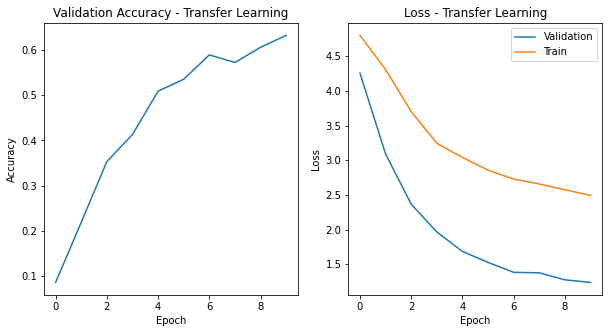

In [117]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))

# val accuracy
axs[0].set_title('Validation Accuracy - Transfer Learning')
axs[0].plot(valid_acc_transfer[1:])
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')

# loss
axs[1].set_title('Loss - Transfer Learning')
axs[1].plot(valid_loss_transfer[1:])
axs[1].plot(train_loss_transfer[1:])
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Validation', 'Train'], loc='upper right')

fig.show()

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [1]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

NameError: ignored

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [ ]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    return None

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](https://github.com/paulovsm/dog-breed-classifier/blob/master/images/sample_human_output.png?raw=1)


### (IMPLEMENTATION) Write your Algorithm

In [ ]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

In [ ]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)

In [2]:
!git add --all . && git commit -m "Training the model with transfer learning" && git push

fatal: not a git repository (or any of the parent directories): .git
